# Preamble

In Part 2 we showed how label correlation can be used to fill in missing labels, helping correct the problem of untested interactions being treated as explicit negatives. 

---

In this part, we look at a different kind of missing label problem.  

In [1]:
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import scipy
from scipy import sparse
from scipy import stats

import sklearn
from sklearn.metrics import pairwise_distances
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KernelDensity
from sklearn.metrics import label_ranking_loss
from sklearn.cluster import AgglomerativeClustering
import pandas as pd

from tqdm import tqdm_notebook

import itertools 
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

import copy

print('Pandas is:', pd.__version__)
print('Numpy is:', np.__version__)
print('Matplot is:', matplotlib.__version__)
print('Scipy is:', scipy.__version__)
print('Sklearn is:', sklearn.__version__)
print('RDKit is:', rdkit.__version__)

Pandas is: 0.24.2
Numpy is: 1.16.4
Matplot is: 3.1.0
Scipy is: 1.3.0
Sklearn is: 0.21.2
RDKit is: 2019.03.2


In [2]:
x = sparse.load_npz('../TheData/x_norm_sparse.npz')
y = sparse.load_npz('../TheData/y.npz')

x = np.array(x.todense())
y = np.array(y.todense())
allSmiles = pd.read_csv('../TheData/allSmiles.csv', header=None)
targetNames = pd.read_csv('../TheData/targetNames.csv', header=None)

# The (other) missing label problem - binding sites

__Some proteins have multiple binding sites__. What's not so commonly known is how common it is for proteins to have multiple binding sites. Ligand gated ion channels are perhaps an extreme example. But recently, with the benefit of fragment screening, people are discovering that both GPCRs[1] and enzymes[2] regularly have multiple sites.

Furthermore, some sites are made up of multiple sub-sites. Recent large-scale docking work has indicated that even a single site might have upwards of 400,000 binding ligands[3]. We think it's unlikely that these all fit into the exact same topology - the orthosteric site can be large, residues move positions, and new cavities  open up - see [4] for a collection of multiple sub-sites within the same site.


If these sites have different shapes, then grouping them on the same protein as a single label violates the similar property principle. This principle says that chemicals with the same binding site have similar structures. As an example, neurosteroids and benzodiazepines both bind GABA-A receptors, but have unrelated structures. This is because they bind to different sites on the protein, and those sites have different shapes. Yet in ChEMBL they are both labelled just as GABA-A receptor ligands. 


Here, we use clustering to separate ligands into their binding sites to improve the performance of machine learning models. What this is really doing is making the job of mapping x-->y easier by making the labels more accurate. 

[1] Ivetac, A., & Andrew McCammon, J. (2010). Mapping the druggable allosteric space of G‐protein coupled receptors: a fragment‐based molecular dynamics approach. Chemical biology & drug design, 76(3), 201-217.

[2] Ludlow, R. F., Verdonk, M. L., Saini, H. K., Tickle, I. J., & Jhoti, H. (2015). Detection of secondary binding sites in proteins using fragment screening. Proceedings of the National Academy of Sciences, 112(52), 15910-15915.

[3] Lyu, J., Wang, S., Balius, T. E., Singh, I., Levit, A., Moroz, Y. S., ... & Tolmachev, A. A. (2019). Ultra-large library docking for discovering new chemotypes. Nature, 566(7743), 224.

[4] Pottel, J., Levit, A., Korczynska, M., Fischer, M., & Shoichet, B. K. (2018). The Recognition of Unrelated Ligands by Identical Proteins. ACS chemical biology, 13(9), 2522-2533.

## A non-parametric method of determining binding site
Like in Part 1, we can generate a sample dataset of Dice distance values. We take Dice distances randomly from within a target (and assume it's a single binding site) vs across different targets (assuming different binding sites). 

In [3]:
## We use 2048-bit fingerprints here because they reduce the influence of bit collisions, which anecdotally
## frustrated the clustering process
from rdkit.Chem import AllChem
mols = [Chem.MolFromSmiles(i) for i in allSmiles[0]]
fpsMorgan = [AllChem.GetMorganFingerprintAsBitVect(m2,2,2048) for m2 in tqdm_notebook(mols)]
x_2_2048 = np.array([[int(i) for i in fp.ToBitString()] for fp in tqdm_notebook(fpsMorgan)])

RDKit WARNING: [10:42:25] Conflicting single bond directions around double bond at index 17.
RDKit WARNING: [10:42:25]   BondStereo set to STEREONONE and single bond directions set to NONE.


In [4]:
from scipy.spatial import distance
same_label = list()
different_label = list()

##Best separation comes from Dice:
vec_distance = lambda a,b: distance.dice(a,b)

for _ in range(30):
    j, k = np.random.choice(y.shape[1], 2, replace=False)
    
    j_instances = x_2_2048[y[:,j]==1]
    k_instances = x_2_2048[y[:,k]==1]
    
    for rep in range(500):
        j_inst = j_instances[np.random.choice(j_instances.shape[0], 1)]
        k_inst = k_instances[np.random.choice(k_instances.shape[0], 1)]
        different_label.append(vec_distance(j_inst, k_inst))
        
    for rep in range(250):
        j1_inst, j2_inst = np.random.choice(j_instances.shape[0], 2, replace=False)
        same_label.append(vec_distance(j_instances[j1_inst], j_instances[j2_inst]))
        
    for rep in range(250):
        k1_inst, k2_inst = np.random.choice(k_instances.shape[0], 2, replace=False)
        same_label.append(vec_distance(k_instances[k1_inst], k_instances[k2_inst]))

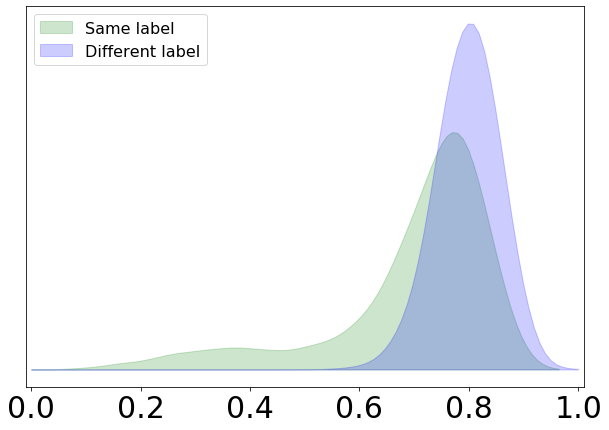

In [5]:
from sklearn.neighbors import KernelDensity
def plotKDE(data, ax, label, c='red', bw=0.025):
    bw=bw
    kde_in = KernelDensity(bandwidth=bw, kernel='gaussian')
    kde_in.fit(np.array(data).reshape(-1,1))

    X_plot = np.linspace(0, max(data), 100)[:, np.newaxis]
    logprob = kde_in.score_samples(X_plot.reshape(-1,1))

    ax.fill_between(X_plot[:,0], np.exp(logprob), alpha=0.2, color=c, label=label)
    
    return ax

ax = plt.axes()
ax.figure.set_size_inches(10,7)
ax = plotKDE(same_label, ax, 'Same label', 'green')
ax = plotKDE(different_label, ax, 'Different label', 'blue')
#ax.set_xlabel('Dice distance', fontsize=15)
#ax.set_ylabel('Prevalence', fontsize=15)

ax.legend()

ax.set_yticks([])
ax.legend(ncol=1, prop={'size': 16}, loc='upper left')
ax.tick_params(labelsize=30)
ax.set_xlim(-0.01,1.01)

ax.figure.savefig('figure_3a_dist.png',facecolor='white', edgecolor='none')




As expected, the Dice distance is smaller for ligands that come from the same protein, which here we just assume means the same binding site. 

This gives us two continuous distributions we can use to analyse any two groups of ligands, and ask whether they come from the same site or a different site. Given two groups of ligands, we first calculate all (or a smaller subsample) of the pairwise Dice distances between the groups. Then we can use the [Kolmogorov-Smirnov statistic](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) to indicate how close the distribution is to  either of the previously determined distributions - the "same-site" distribution, or "different-site" distribution. 

This inherits a bit from the similarity ensemble approach[1]

[1]Keiser, M. J., Roth, B. L., Armbruster, B. N., Ernsberger, P., Irwin, J. J., & Shoichet, B. K. (2007). Relating protein pharmacology by ligand chemistry. Nature biotechnology, 25(2), 197.

# Clustering into binding sites


Because we don't know how many binding sites exist on each protein, we seek a clustering algorithm that requires no input for the number of clusters, which means we can't use k-means. We also don't know the structure of the ligand sets in fingerprint-space, so we need it to accept non-normal clusters. That means no DBSCAN. Preferably it is fast with few tunable hyperparameters too. __sklearn__ offers a great implementation of agglomerative clustering, which doesn't require the number of clusters as input. It is capable of clustering just by using a distance threshold.

A good starting point for clustering is to cluster a little too much, and then merge the clusters afterwards. We did this by combining agglomerative clustering (with a threshold of dice=0.8, creating about 5-10 clusters) with the Kolmogorov-Smirnov statistic. This statistic tells you whether two clusters are more likely to arise from the same-label (red above) or different-label (blue above) distributions.

The clustering can be done on a laptop, but the performance evaluation requires more CPUs. The code for clustering and evaluation is in the github, here we just show the results.

In [6]:
#Load up the ranking losses of the original labels (before clustering)
performance_original_labels = list()
for targ in range(y.shape[1]):
    rloss = np.load('../Part_2/comparison_full/target_'+str(targ)+'_threshold1.npy')
    performance_original_labels.append(np.median(rloss))

In [7]:
#load up the dictionary to map original targetIDs to the new clustered IDs
target_id_map = dict()
for count, entry in enumerate([i.strip('\n').split() for i in open('y_cluster_map.dat').readlines()]):
    if len(entry)>2:
        target_id_map[count]=list()
        for tmap in entry[1:]:
            target_id_map[count].append(tmap)

In [8]:
#load up the clustered label set performances
from scipy import sparse
#y_cluster_sparse = sparse.load_npz('y_cluster.npy')
#y_cluster = y_cluster_sparse.toarray()
y_cluster = np.load('y_cluster.npy')

cluster_performances = dict()
    
for j,k in target_id_map.items():
    if len(k)>1:
        num_old = np.sum(y[:,j])
        cluster_performances[j]=list()
        rlosses = 0
        for targ in k:
            num_new = np.sum(y_cluster[:,int(targ)])
            rloss = np.load('cluster_full/target_'+str(targ)+'.npy')
            weighted_rloss = np.median(rloss) * num_new/num_old
            rlosses+=weighted_rloss
        cluster_performances[j].append(rlosses)

Not all targets get clustered. Observe:

In [9]:
num_clusters = list()
for targ in range(243):
    try:
        new_targets = target_id_map[targ]
        num_clusters.append(len(new_targets))
    except:
        num_clusters.append(1)
        
num_clusters=np.array(num_clusters)

Text(0.5, 0, 'Number of clusters')

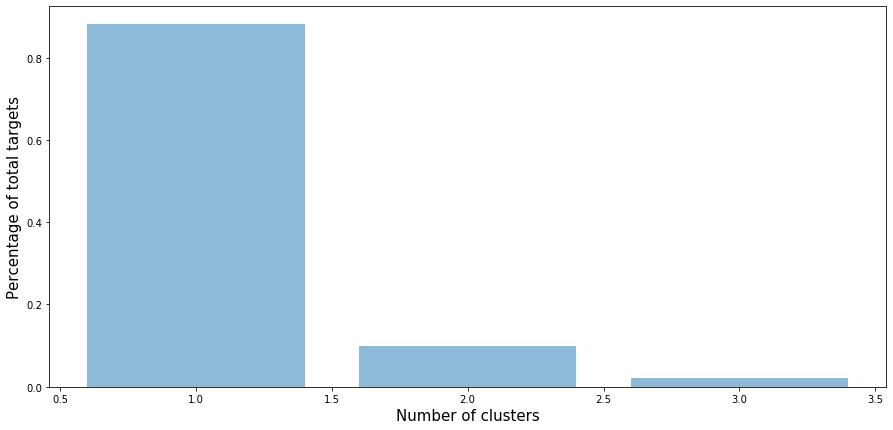

In [10]:
ax = plt.axes()
ax.figure.set_size_inches(15,7)

bars = list()
for num in range(1,4):
    bars.append(np.sum(num_clusters==num))
    
ax.bar([1,2,3], np.array(bars)/243, alpha=0.5)
ax.set_ylabel('Percentage of total targets', fontsize=15)
ax.set_xlabel('Number of clusters', fontsize=15)

Looks like the clustering approach isn't overzealous - most targets remain as a single cluster. But a solid number targets have 2 or 3 clusters. The next question to ask is: when we change the label matrix to reflect these clusters - do the new labels perform better or worse? 


Below shows the relative performance of the labels that got clustered, compared to their unclustered version. To do the comparison, the ranking loss of the multiple clusters is weighted by the number of ligands in that cluster to become a single ranking loss, allowing direct comparison to the original label. 

-0.12612612612612617


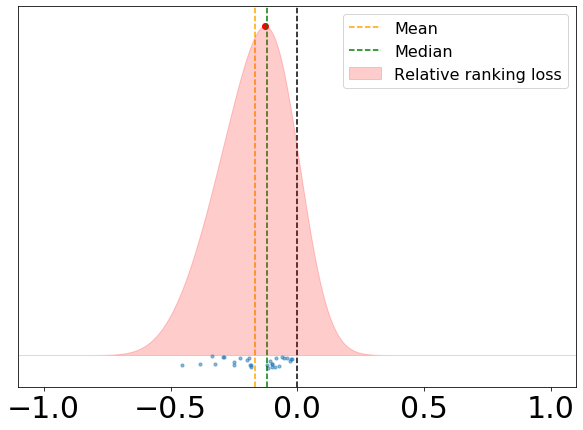

In [11]:
compare=list()
for j,k in target_id_map.items():
    if len(k)>1:
        compare.append((cluster_performances[j]/performance_original_labels[j])[0])

def plot_clusterKDE(data, ax, label, c='red', bw=1):
    bw=bw
    kde_in = KernelDensity(bandwidth=bw, kernel='gaussian')
    kde_in.fit(np.array(data).reshape(-1,1))

    X_plot = np.linspace(-2, 2, 1000)[:, np.newaxis]
    logprob = kde_in.score_samples(X_plot.reshape(-1,1))

    ax.fill_between(X_plot[:,0], np.exp(logprob), alpha=0.2, color=c, label=label, zorder=10)
    maxPoint = np.argmax(np.exp(logprob))
    ax.scatter(X_plot[:,0][maxPoint], np.exp(logprob[maxPoint]), color=c)
    ax.axvline(0, linestyle='--', c='black')
    print(X_plot[:,0][maxPoint])
    return ax
        
        
ax = plt.axes()
ax.figure.set_size_inches(10,7)

#ax.grid(linestyle='--', alpha=0.4, zorder=1)
#ax.set_axisbelow(True)
#ax.yaxis.grid(color='gray', linestyle='--', alpha=0.1)


ax = plot_clusterKDE(np.log10(compare), ax, 'Relative ranking loss', 'red', bw=0.10)
#ax.set_xlabel('Log of relative ranking loss of clustered labels', fontsize=15)
#ax.set_ylabel('Density', fontsize=15)

ax.axvline(np.mean(np.log10(compare)), linestyle='--',color='orange', label='Mean')
ax.axvline(np.median(np.log10(compare)), linestyle='--', color='green', label='Median')
ax.legend()
ax.scatter(np.log10(compare), np.random.uniform(-0.1,0, len(compare)), s=10, alpha=0.5)



ax.set_yticks([])
ax.legend(ncol=1, prop={'size': 16}, loc='upper right')
ax.tick_params(labelsize=30)
ax.set_xlim(-1.1,1.1)


ax.figure.savefig('figure_3c_rel_rloss.png',facecolor='white', edgecolor='none')

In [12]:
#mean log relative performance:
np.mean(np.log10(compare))

-0.16774874670174705

In [13]:
#numnber of targets that clustered into multiple sites.
len(compare) / 243

0.11934156378600823

In [14]:
#percentage improvement on average:
10**-0.16774874670174705

0.6795966874069378

## The clustered labels perform better!

There is a clear signal here - a big majority of the labels that get clustered into different binding sites perform better using those cluster labels for training compared to the original labels. Here, 'better' performance for the clustered labels means being left of the black dotted line.



# BONUS: Clustering GABA-A receptor ligands
It's nice to have a visual confirmation that clustering really is putting ligands into groups that could sensibly be binding sites. Let's look at an extreme example, a GABA-A receptor from ChEMBL, which we think has a good balance between ligand set size and diversity of binding sites. There are 300-400 ligands, and at least 4 sites in this label (CHEMBL2093872): 
* pore-blocking site, 
* neurosteroid site,  
* diazepam site, 
* endogenous orthosteric site

The following bunch of code just downloads the dataset, cleans it and creates the fingerprints.

In [15]:
accession = 'CHEMBL2093872'

def getAllRecords(accession, pchembl, total_count):
    ligandList = []
    urlString = "https://www.ebi.ac.uk/chembl/api/data/activity.json?target_chembl_id__exact=%s&pchembl_value__gt=%s&limit=%s" % (accession, pchembl, total_count)
    #urlString = "https://www.ebi.ac.uk/chembl/api/data/activity.json?target_chembl_id__exact=%s&limit=%s" % (accession, total_count)
    
    webQuery = json.loads(requests.get(urlString).content)
    activities = webQuery['activities']
    ligandList.extend(activities)
    numrepeats = math.ceil(float(total_count)/1000)
    while webQuery['page_meta']['next']:
    #for repeat in range(numrepeats-1):
        urlString = "https://www.ebi.ac.uk"+webQuery['page_meta']['next']
        webQuery = json.loads(requests.get(urlString).content)
        activities = webQuery['activities']
        ligandList.extend(activities)
        print('Loaded', len(ligandList), 'of', total_count)
    return(ligandList)

#this just makes a neater list with only the interesting things: CHEMBLID, common name, pchembl_value, smiles
def parseLigands(ligandList):
    newList = [(item['molecule_chembl_id'], item['molecule_pref_name'], item['pchembl_value'], item['canonical_smiles']) for item in ligandList]
    return(newList)

#this just groups multiple measurements together (into a list) for each ligand
def sortLigands(ligandList):
    newList = []
    chemblids = set([item[0] for item in ligandList])
    for id in chemblids:
        ligands = [item for item in ligandList if item[0]==id]
        newList.append(ligands)
    return(newList)

#this averages the pchembl values for all the measurements, for each ligand.
def averageLigands(ligandList):
    avgList = []
    for item in ligandList:
        if len(item)>1:
            allRecords = [float(measurement[2]) for measurement in item]
            avg = sum(allRecords) / len(allRecords)
            result = [(item[0][0], item[0][1], avg, item[0][3])]
        else:
            result = item
        avgList.append(result)
    return(avgList)

In [16]:
import json
import requests
import math
pchembl=5
print('Counting bioactivities:')
urlString = "https://www.ebi.ac.uk/chembl/api/data/activity.json?target_chembl_id__exact=%s&pchembl_value__gt=%s" % (accession, pchembl)
webQuery = json.loads(requests.get(urlString).content)
total_count = webQuery['page_meta']['total_count']
print(total_count)

ligandList = getAllRecords(accession, pchembl, total_count)
ligands = parseLigands(ligandList)
print('Of', len(ligands), 'ligand records,')
ligandsSorted = sortLigands(ligands)
print('got', len(ligandsSorted), 'unique ligands')
ligandsAveraged = ligandsSorted
print('Averaged all', len(ligandsAveraged), 'ligands')

smiles = ligandsAveraged
smiles = [i[0] for i in smiles]
len(smiles)

Counting bioactivities:
429
Of 429 ligand records,
got 365 unique ligands
Averaged all 365 ligands


365

In [17]:
from rdkit.Chem import SaltRemover
from rdkit.Chem import Descriptors

remover = Chem.SaltRemover.SaltRemover(defnData="[Cl,Br,I,Ca,Zn,Li,Na,K,Mg,B,Ag]")

def sanitizeMols(ligands):
    saltmols = list()
    mols = list()
    for lig in ligands:
        try:
            mol = Chem.MolFromSmiles(lig[3])
            if mol:
                nosaltmol = remover.StripMol(mol)
                molwt = Chem.Descriptors.MolWt(nosaltmol)
                if molwt<800 and molwt>90:
                    Chem.RemoveHs(nosaltmol)
                    if lig[1]:
                        nosaltmol.SetProp('Name', lig[1])
                    else:
                        nosaltmol.SetProp('Name', lig[0])
                    mols.append(nosaltmol)      
        except:
            print('screwup')
            continue
    return mols

gaba_mols = sanitizeMols(smiles)

## Sanity check -- are these GABAAR ligands?

yes

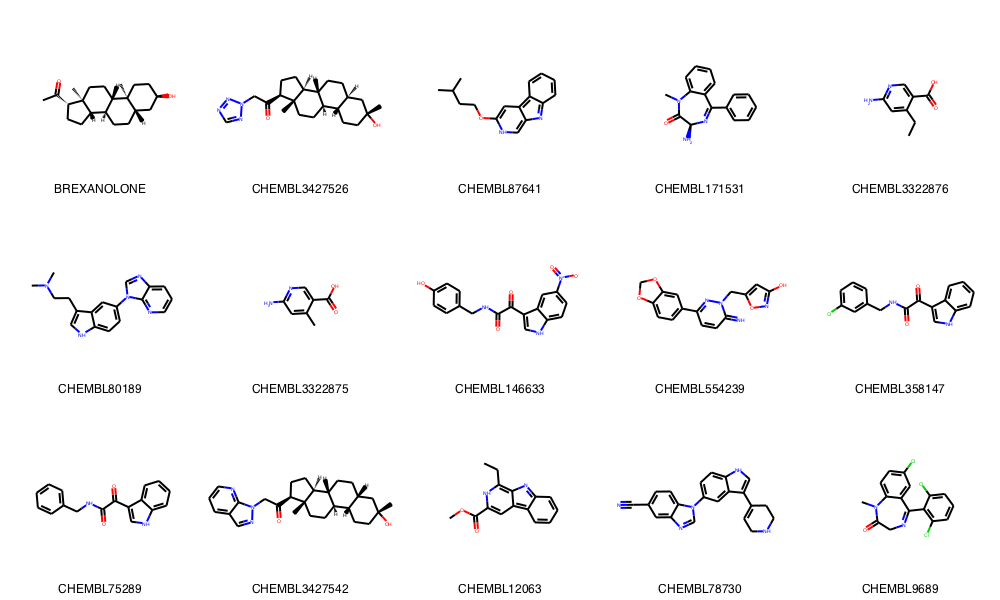

In [18]:
#sanity check - do these look like gaba ligands?
smap = np.random.choice(gaba_mols, 15, replace=False)
labs = [mo.GetProp('Name') for mo in smap]
Draw.MolsToGridImage(smap, molsPerRow=5, legends=labs)

##Yes

In [19]:
fpsMorgan = [AllChem.GetMorganFingerprintAsBitVect(mol,2,2048) for mol in tqdm_notebook(gaba_mols)] 
x_gaba_2_2048 = np.array([[int(i) for i in fp.ToBitString()] for fp in tqdm_notebook(fpsMorgan)])

x_gaba = copy.copy(x_gaba_2_2048)


distance_matrix = pairwise_distances(np.array(x_gaba, dtype=bool), metric='dice')

## What do the dice distances for the gaba ligands look like?

You can see below that, despite all pairs coming from the same label, there is some skew of the ligand distances (green) towards the 'less similar' direction. This is consistent with our _a priori_ knowledge that the set has multiple binding sites - the comparisons between ligands from two different sites naturally have larger Dice distances because they are highly dissimilar.

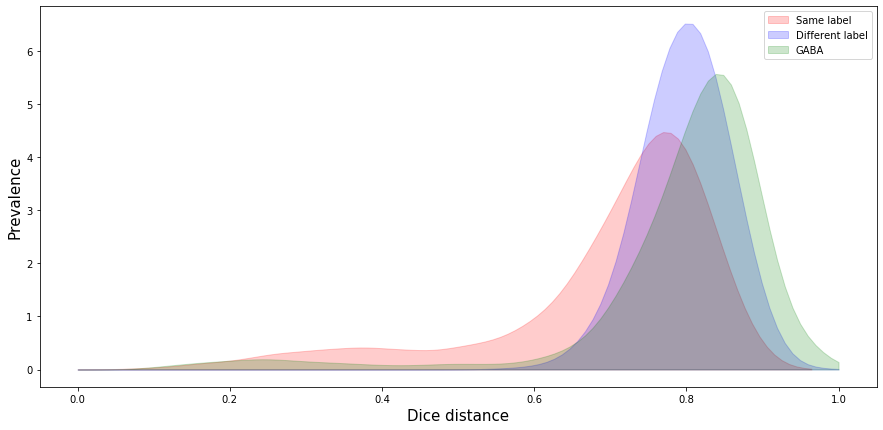

In [20]:
def plotKDE(data, ax, label, c='red', bw=0.025):
    bw=bw
    kde_in = KernelDensity(bandwidth=bw, kernel='gaussian')
    kde_in.fit(np.array(data).reshape(-1,1))

    X_plot = np.linspace(0, max(data), 100)[:, np.newaxis]
    logprob = kde_in.score_samples(X_plot.reshape(-1,1))

    ax.fill_between(X_plot[:,0], np.exp(logprob), alpha=0.2, color=c, label=label)
    
    return ax

ax = plt.axes()
ax.figure.set_size_inches(15,7)
ax = plotKDE(same_label, ax, 'Same label', 'red')
ax = plotKDE(different_label, ax, 'Different label', 'blue')
ax = plotKDE(distance_matrix[distance_matrix>0], ax, 'GABA', 'green')
ax.set_xlabel('Dice distance', fontsize=15)
ax.set_ylabel('Prevalence', fontsize=15)

ax.legend()
#plt.hist(distance_matrix[distance_matrix>0], bins=100)

# Let's cluster

The below clusters the GABA-A receptor ligands using the hybrid agglomerative-kolmogorov-smirnov clusterer

In [21]:
def getPairPredictions(clusters, distance_matrix, sames, differents, verbose=0):
    pairList = dict()
    pList = list()
    if verbose:
        print('Calculating pairwise probabilities for %s clusters' % len(clusters))

    count=0
    for p1,p2 in itertools.combinations(range(len(clusters)), 2):
        print(p1,' ', p2, end='\r')
        indices = np.concatenate([clusters[p1], clusters[p2]])
        joined_matrix = copy.copy(distance_matrix[indices][:,indices])      
        #joined_matrix = copy.copy(distance_matrix[clusters[p1]][:,clusters[p2]])
        
        flattened_joined = joined_matrix[joined_matrix>0]
        joined_ks_same = stats.ks_2samp(sames,  flattened_joined)[0]
        joined_ks_diff = stats.ks_2samp(differents,  flattened_joined)[0]

        pList.append(joined_ks_diff/joined_ks_same)

        pairList[count] = [p1,p2]
        count+=1
    biggest = np.argmax(pList)
    print(biggest, pList[biggest])
    if pList[biggest]>1:
        maxPair = pairList[biggest]
        p1,p2=maxPair
        clusters[p1] = np.concatenate([clusters[p1], clusters[p2]])
        mask = np.ones(len(clusters), bool)
        mask[p2]=False
        clusters = np.array(clusters)[mask]
        return list(clusters)
    else: 
        return clusters
    
sample_dist = lambda a: np.random.choice(a, 500, replace=False)
same_sample = sample_dist(same_label)
different_sample = sample_dist(different_label)

In [22]:
distance_matrix = pairwise_distances(np.array(x_gaba, dtype=bool), metric='dice')
clusterer = AgglomerativeClustering(n_clusters=None,
                                     affinity='precomputed', 
                                     linkage='average',
                                    distance_threshold=0.8)
clusterer.fit(distance_matrix)

numclust = clusterer.labels_.max()+1
clusters = [np.where(clusterer.labels_==i)[0] for i in range(numclust)]
print([len(c) for c in clusters])


same_sample = sample_dist(same_label)
different_sample = sample_dist(different_label)



while len(clusters)>1:
    oldnum = copy.copy(numclust)
    clusters = getPairPredictions(clusters, 
                                      distance_matrix, 
                                      same_label, 
                                  different_label,
                                 verbose=1) #threshold is the confidence 
            #that two clusters are the SAME. Set low to join clusters, high to separate clusters. 
    numclust= len(clusters)

    if numclust==oldnum:
        break
            

print('DONE, number of clusters is %s' % len(clusters))



[143, 11, 79, 15, 36, 18, 9, 34, 20]
Calculating pairwise probabilities for 9 clusters
5 3.3604705438366502
Calculating pairwise probabilities for 8 clusters
17 3.168764592427165
Calculating pairwise probabilities for 7 clusters
6 2.5643531236004042
Calculating pairwise probabilities for 6 clusters
1 1.6741148022280514
Calculating pairwise probabilities for 5 clusters
7 1.2636784869548465
Calculating pairwise probabilities for 4 clusters
4 0.7309811445726325
DONE, number of clusters is 4


In [23]:
def printNames(clusters):
    moleculesClustered = [[gaba_mols[index] for index in indices] for indices in clusters] 

    for count, cluster in enumerate(moleculesClustered):
        names = [mol.GetProp('Name') for mol in cluster]
        print(count, [item for item in names if 'CHEMBL' not in item])

printNames(clusters)

0 ['BETA-CCM', 'NORHARMANE', 'DELORAZEPAM', 'CLONAZEPAM', 'RO-223294', 'DIAZEPAM', 'PITRAZEPINE', 'CGS-8216', 'CGS-9896', 'ISOGUVACINE', 'ISONIPECOTIC ACID', 'GAMMA-AMINOBUTYRIC ACID']
1 ['FLUMAZENIL', 'BICUCULLINE', 'BAICALEIN', 'AMENTOFLAVONE', 'CHRYSIN', '6-BROMOFLAVONE', 'FLAVONE', 'HISPIDULIN', 'WOGONIN', 'APIGENIN', 'GABAZINE', 'MUSCIMOL']
2 ['FIPRONIL']
3 ['BREXANOLONE', 'GANAXOLONE']


In [24]:
from rdkit.Chem.Draw import DrawingOptions
DrawingOptions.dotsPerAngstrom = 300
DrawingOptions.bondLineWidth = 3.0
DrawingOptions.atomLabelFontSize = 200

names = np.array([i.GetProp('Name') for i in gaba_mols])
for name in ['FLAVONE', 'MUSCIMOL', 'GANAXOLONE', 'BREXANOLONE', 
             'FIPRONIL', 'CHEMBL88721', 'DIAZEPAM', 'BETA-CCM']:
    print(name)
    idx = np.where(names==name)[0][0]
    Draw.MolToFile(gaba_mols[idx], './'+name+'.svg')

FLAVONE
MUSCIMOL
GANAXOLONE
BREXANOLONE
FIPRONIL
CHEMBL88721
DIAZEPAM
BETA-CCM


## Clusters align well with binding sites

The lists above show the cluster ID number followed by the names of those ligands with common-name entries in chembl that belong to that cluster. Remarkably, not only are clusters like the neurosteroids (cluster 3 - brexanolone and ganaxolone) pulled out separately, but several scaffolds existing within the same binding site are also clustered together. In particular observe the pore blocking ligands below (cluster 2 above), the benzodiazepine-site binding ligands like Diazepam and Beta-CCM (cluster 0 above), or the GABA-site binding ligands like Muscimol and the flavones (cluster 1).

There are some incorrect groupings, like Pitrazepine and GABA being grouped with the benzodiazepine binding site, but on the whole the clustering is a huge improvement.

See these molecules below:

## Pore blocking insecticide site:

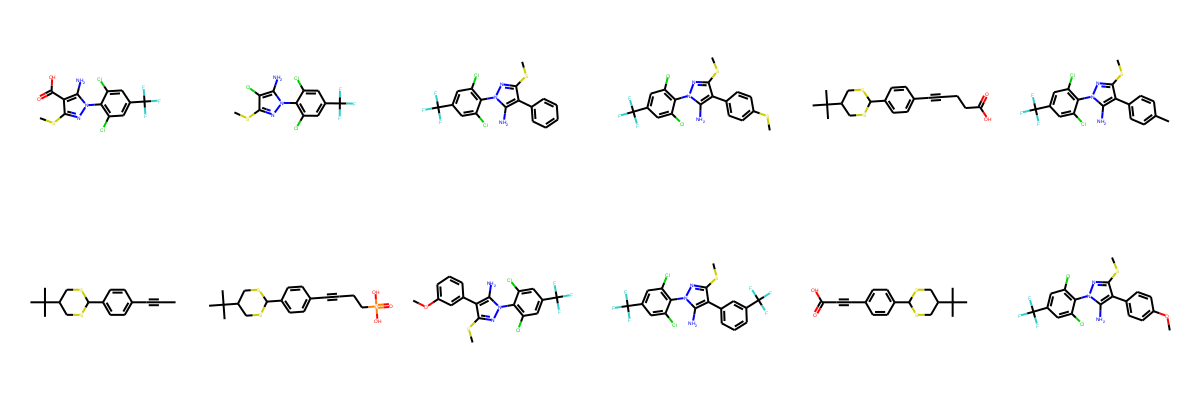

In [25]:
Draw.MolsToGridImage(np.random.choice(np.array(gaba_mols)[clusters[2]],12,replace=False), molsPerRow=6, maxMols=12)


## Allosteric Neurosteroid site:

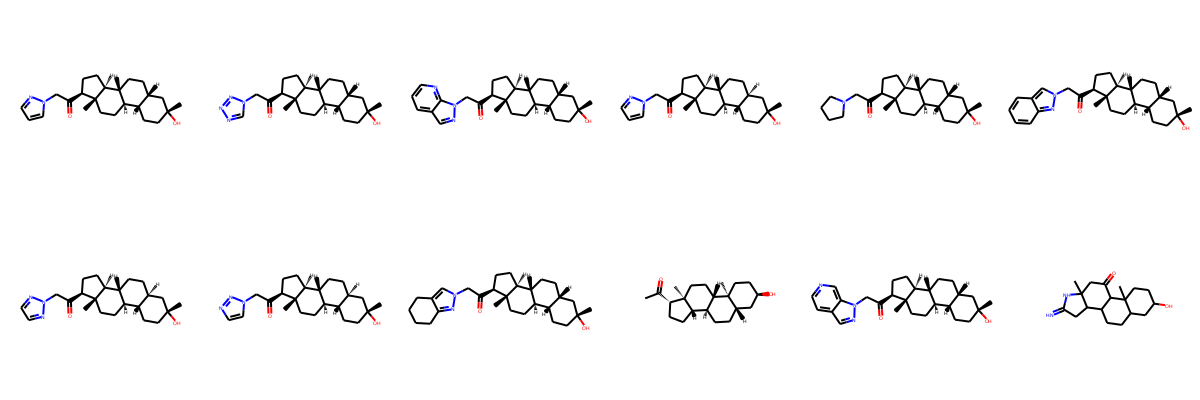

In [26]:
Draw.MolsToGridImage(np.random.choice(np.array(gaba_mols)[clusters[3]],12,replace=False), molsPerRow=6, maxMols=12)


## Allosteric Benzodiazepine site:

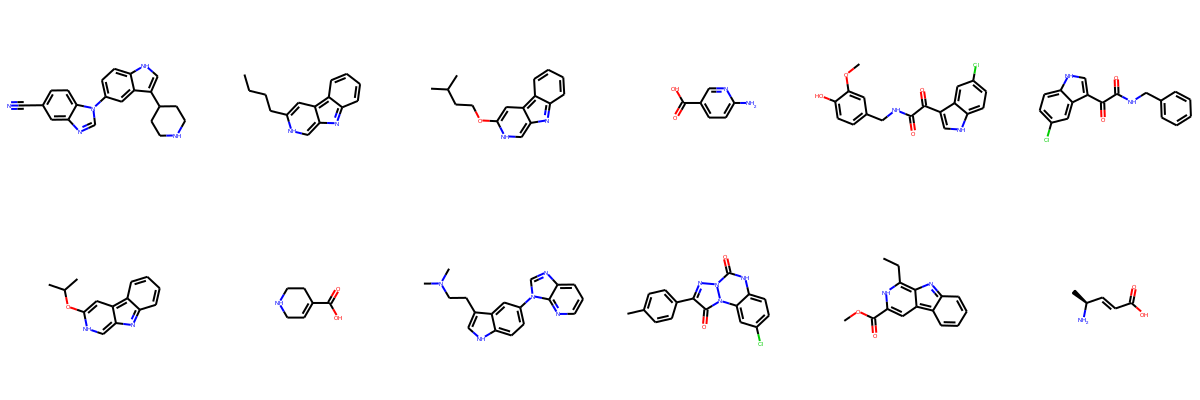

In [29]:
Draw.MolsToGridImage(np.random.choice(np.array(gaba_mols)[clusters[0]],12,replace=False), molsPerRow=6, maxMols=12)


## Orthosteric GABA/Flavone site

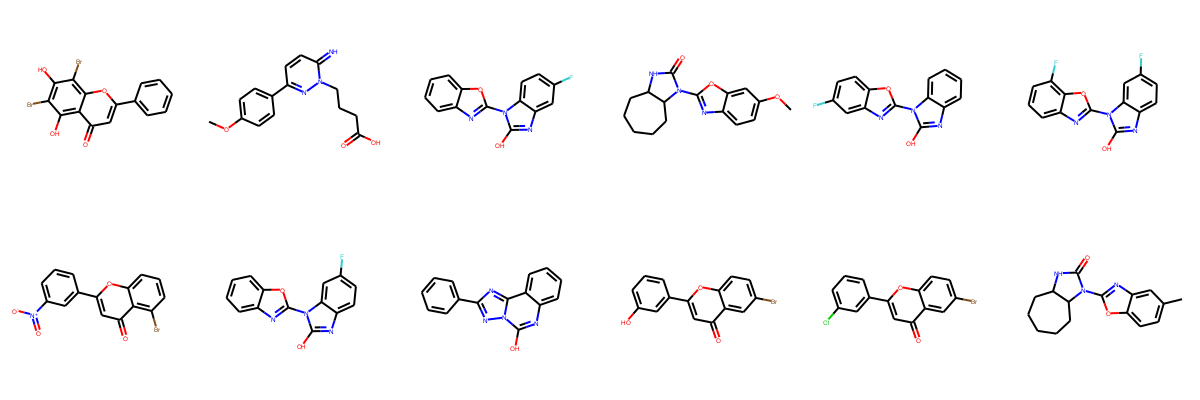

In [28]:
Draw.MolsToGridImage(np.random.choice(np.array(gaba_mols)[clusters[1]],12,replace=False), molsPerRow=6, maxMols=12)

